Initial code for EELS analysis using quantum algorithms

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

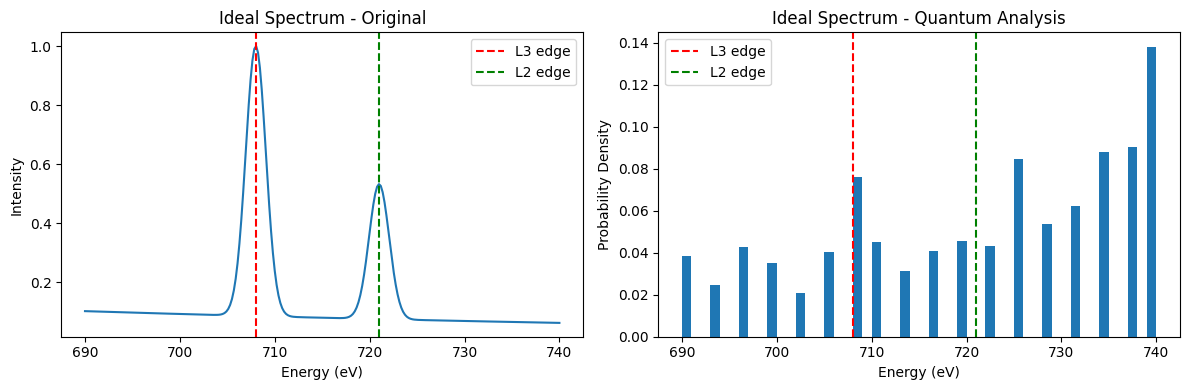

Detected peaks for Ideal Spectrum:
  696.00 eV
  702.00 eV
  709.00 eV
  719.00 eV
  725.00 eV
  734.00 eV


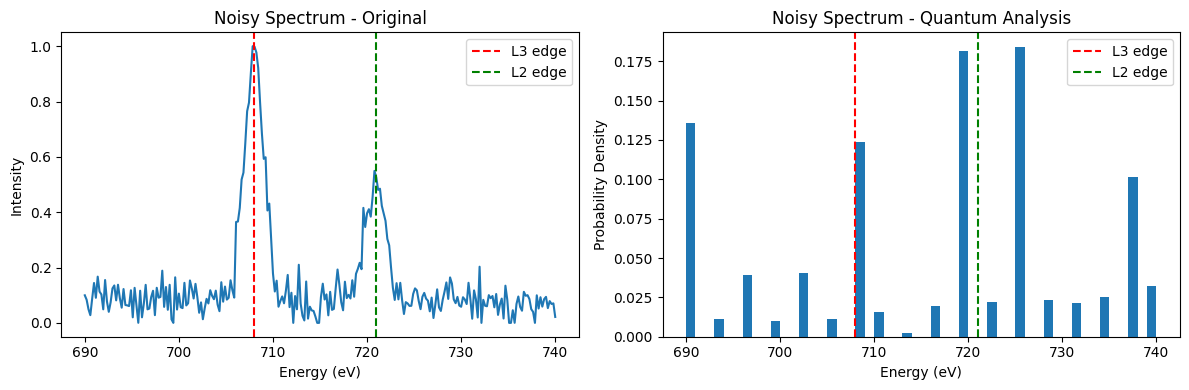

Detected peaks for Noisy Spectrum:
  696.00 eV
  702.00 eV
  708.00 eV
  713.00 eV
  719.00 eV
  725.00 eV
  731.00 eV
  737.00 eV


In [36]:
def generate_fe_l23_spectrum(energy_range, add_noise=False):
    l3_peak, l2_peak = 708, 721
    fwhm = 1.5
    l3_intensity = np.exp(-((energy_range - l3_peak) / fwhm)**2)
    l2_intensity = 0.5 * np.exp(-((energy_range - l2_peak) / fwhm)**2)
    background = 0.1 * np.exp(-(energy_range - 700) / 100)
    spectrum = l3_intensity + l2_intensity + background
    if add_noise:
        noise = np.random.normal(0, 0.05, energy_range.shape)
        spectrum += noise
        spectrum = np.maximum(spectrum, 0)
    return spectrum / np.max(spectrum)

def apply_iqft(qc, qubits):
    """Apply inverse QFT to the given qubits"""
    for i in range(len(qubits)):
        for j in range(i):
            qc.cp(-np.pi / 2**(i-j), qubits[i], qubits[j])
        qc.h(qubits[i])

def quantum_eels_encoding(spectrum, n_qubits=8):
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)

    # Encode spectrum into quantum state
    for i, amplitude in enumerate(spectrum):
        qc.ry(np.pi * amplitude, qr[i % n_qubits])

    # Apply some entangling operations
    for i in range(n_qubits - 1):
        qc.cx(qr[i], qr[i+1])

    # Apply inverse QFT
    apply_iqft(qc, qr)

    # Measure in computational basis
    qc.measure(qr, cr)

    return qc

def quantum_eels_analysis(spectrum, energy_range, n_qubits=8, shots=100000):
    qc = quantum_eels_encoding(spectrum, n_qubits)

    # Run the circuit
    simulator = AerSimulator()
    job = simulator.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)

    # Process results
    energies = []
    max_energy = energy_range[-1]
    for bitstring, count in counts.items():
        energy = int(bitstring, 2) * max_energy / (2**n_qubits - 1)
        energies.extend([energy] * count)

    return energies

def analyze_and_plot(spectrum, energy_range, title):
    simulated_energies = quantum_eels_analysis(spectrum, energy_range)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(energy_range, spectrum)
    plt.title(f"{title} - Original")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Intensity")
    plt.axvline(x=708, color='r', linestyle='--', label='L3 edge')
    plt.axvline(x=721, color='g', linestyle='--', label='L2 edge')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(simulated_energies, bins=50, range=(energy_range[0], energy_range[-1]), density=True)
    plt.title(f"{title} - Quantum Analysis")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Probability Density")
    plt.axvline(x=708, color='r', linestyle='--', label='L3 edge')
    plt.axvline(x=721, color='g', linestyle='--', label='L2 edge')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Find peaks in the quantum analysis results
    hist, bin_edges = np.histogram(simulated_energies, bins=50, range=(energy_range[0], energy_range[-1]))
    smoothed_hist = savgol_filter(hist, window_length=5, polyorder=3)
    peaks, _ = find_peaks(smoothed_hist, distance=5)
    peak_energies = bin_edges[peaks]
    
    print(f"Detected peaks for {title}:")
    for peak in peak_energies:
        print(f"  {peak:.2f} eV")

if __name__ == "__main__":
    energy_range = np.linspace(690, 740, 256)
    
    ideal_spectrum = generate_fe_l23_spectrum(energy_range, add_noise=False)
    analyze_and_plot(ideal_spectrum, energy_range, "Ideal Spectrum")
    
    noisy_spectrum = generate_fe_l23_spectrum(energy_range, add_noise=True)
    analyze_and_plot(noisy_spectrum, energy_range, "Noisy Spectrum")

In [10]:
## Plot Primitives

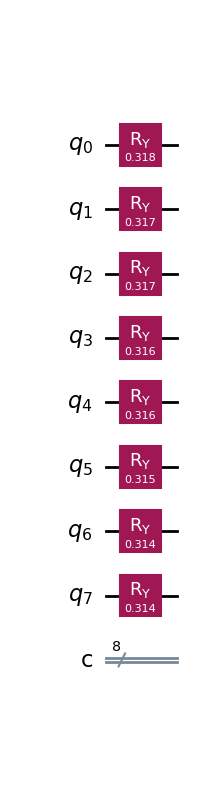

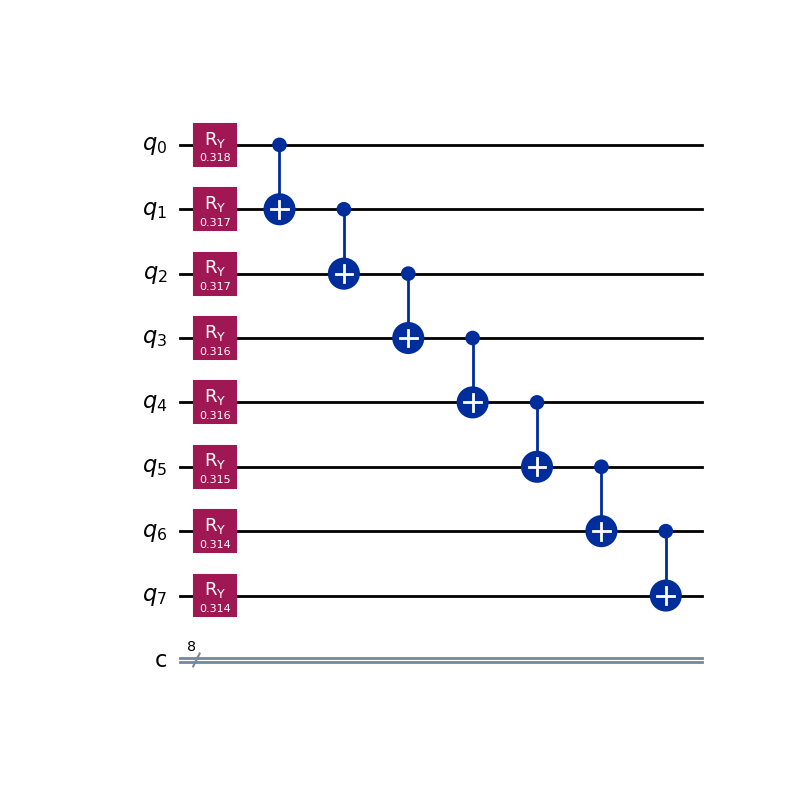

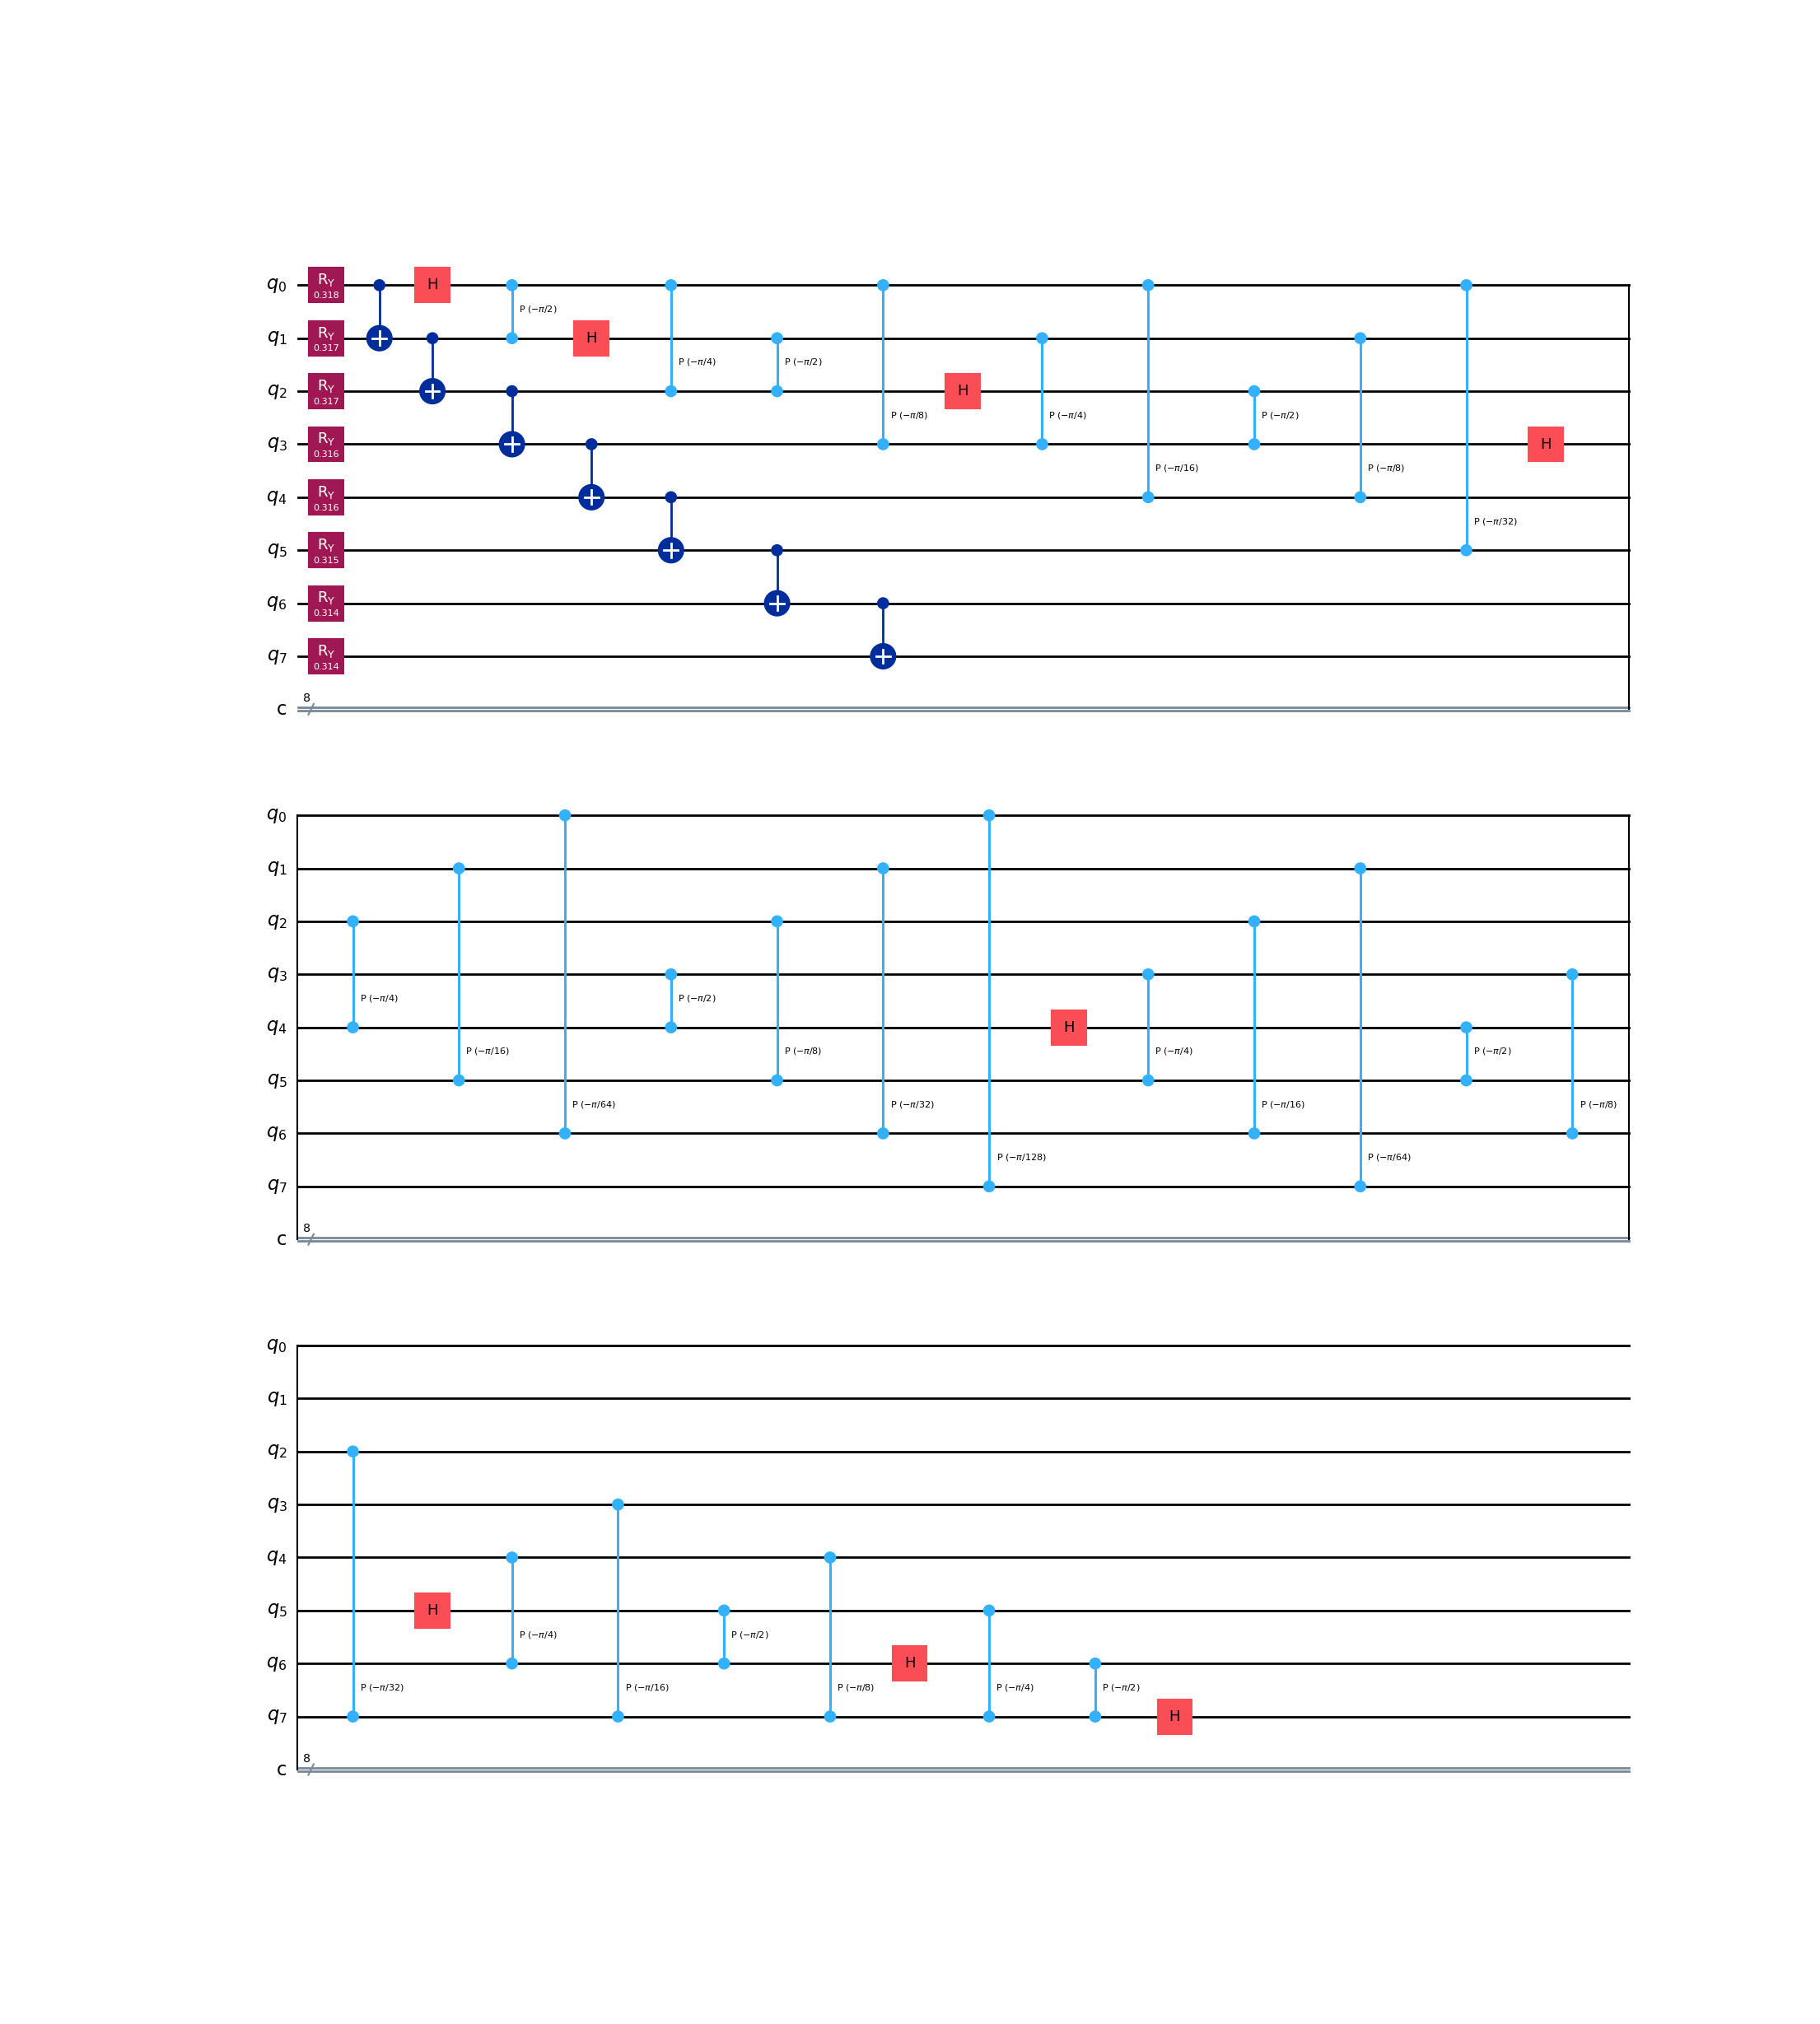

In [9]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

def generate_fe_l23_spectrum(energy_range, add_noise=False):
    l3_peak, l2_peak = 708, 721
    fwhm = 1.5
    l3_intensity = np.exp(-((energy_range - l3_peak) / fwhm)**2)
    l2_intensity = 0.5 * np.exp(-((energy_range - l2_peak) / fwhm)**2)
    background = 0.1 * np.exp(-(energy_range - 700) / 100)
    spectrum = l3_intensity + l2_intensity + background
    if add_noise:
        noise = np.random.normal(0, 0.05, energy_range.shape)
        spectrum += noise
        spectrum = np.maximum(spectrum, 0)
    return spectrum / np.max(spectrum)

def apply_iqft(qc, qubits):
    """Apply inverse QFT to the given qubits"""
    for i in range(len(qubits)):
        for j in range(i):
            qc.cp(-np.pi / 2**(i-j), qubits[i], qubits[j])
        qc.h(qubits[i])

# Generate a sample spectrum
energy_range = np.linspace(690, 740, 256)
sample_spectrum = generate_fe_l23_spectrum(energy_range, add_noise=False)

# Step 1: Quantum State Preparation
qr = QuantumRegister(8, 'q')
cr = ClassicalRegister(8, 'c')
qc_state_prep = QuantumCircuit(qr, cr)

for i, amplitude in enumerate(sample_spectrum[:8]):
    qc_state_prep.ry(np.pi * amplitude, qr[i % 8])

# Draw the circuit for Quantum State Preparation
circuit_image_state_prep = circuit_drawer(qc_state_prep, output='mpl', plot_barriers=False, justify='left')
circuit_image_state_prep.savefig('quantum_state_preparation.png')

# Step 2: Entangling Operations
qc_entangling = qc_state_prep.copy()

for i in range(7):
    qc_entangling.cx(qr[i], qr[i+1])

# Draw the circuit for Entangling Operations
circuit_image_entangling = circuit_drawer(qc_entangling, output='mpl', plot_barriers=False, justify='left')
circuit_image_entangling.savefig('entangling_operations.png')

# Step 3: Inverse Quantum Fourier Transform (IQFT)
qc_iqft = qc_entangling.copy()
apply_iqft(qc_iqft, qr)

# Draw the circuit for Inverse QFT
circuit_image_iqft = circuit_drawer(qc_iqft, output='mpl', plot_barriers=False, justify='left')
circuit_image_iqft.savefig('iqft.png')

# Display the saved images
from IPython.display import Image, display
display(Image(filename='quantum_state_preparation.png'))
display(Image(filename='entangling_operations.png'))
display(Image(filename='iqft.png'))
